## Mô hình Transformer tốt nhất 

2024-06-12 00:16:45.445551: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-12 00:16:45.483928: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 00:16:45.484125: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 00:16:45.485061: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-12 00:16:45.495286: I tensorflow/core/platform/cpu_feature_guar

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 1)]      0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 30, 1)       2           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 30, 1)       7169        ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

2024-06-12 00:16:47.241501: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-12 00:16:47.339576: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-12 00:16:47.339619: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-12 00:16:47.345150: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-12 00:16:47.345206: I external/local_xla/xla/stream_executor

Epoch 1/50


2024-06-12 00:16:50.496779: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fdded361da0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-12 00:16:50.496820: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-06-12 00:16:50.509009: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-12 00:16:50.535925: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1718126210.593802  135334 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


45/45 [==============================] - 4s 17ms/step - loss: 0.0041 - val_loss: 0.0015
Epoch 2/50
45/45 [==============================] - 1s 12ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 3/50
45/45 [==============================] - 0s 11ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 4/50
45/45 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 5/50
45/45 [==============================] - 1s 11ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 6/50
45/45 [==============================] - 1s 12ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 7/50
45/45 [==============================] - 0s 10ms/step - loss: 9.1841e-04 - val_loss: 0.0030
Epoch 8/50
45/45 [==============================] - 0s 10ms/step - loss: 7.9242e-04 - val_loss: 0.0026
Epoch 9/50
45/45 [==============================] - 0s 10ms/step - loss: 7.3177e-04 - val_loss: 0.0017
Epoch 10/50
45/45 [==============================] - 0s 10ms/step - loss: 6.4419e-04 - val_loss: 0.0018
Epoc

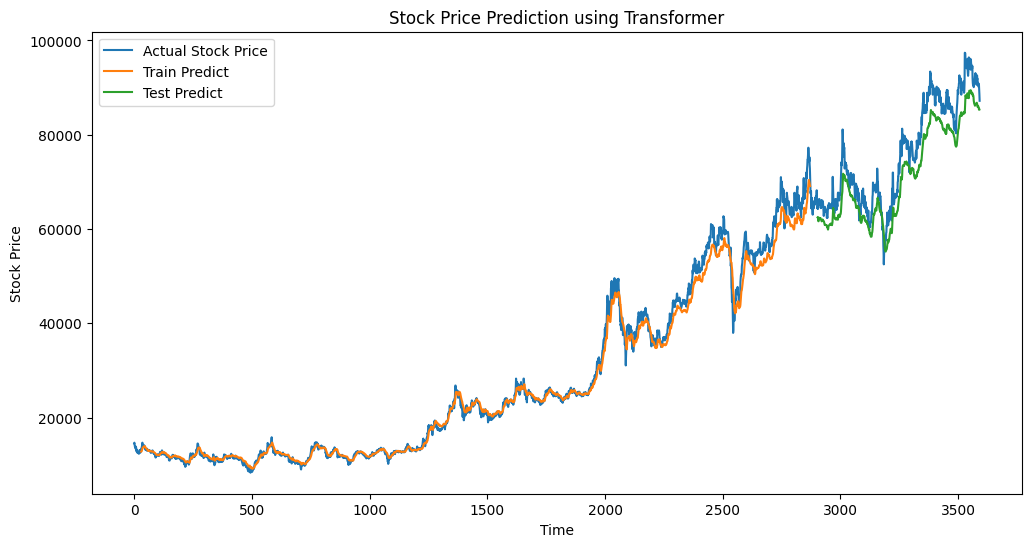

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D
from sklearn.metrics import mean_squared_error, r2_score
import math
import matplotlib.pyplot as plt
import os

# Load and prepare the dataset
file_path = '/mnt/d/code/TimeSeries/Nhom1_CuoiKi_TimeSeries/Data/vcb_2010-2024.csv'  # Make sure to have your dataset ready
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df[::-1].reset_index(drop=True)
df.set_index('Date', inplace=True)
data = df[['Close']].values
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Parameters
time_step = 30
training_size = int(len(data_scaled) * 0.8)
test_size = len(data_scaled) - training_size
train_data, test_data = data_scaled[0:training_size,:], data_scaled[training_size:len(data_scaled),:]

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input for the model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Transformer Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

# Model Definition
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = transformer_encoder(inputs, head_size=256, num_heads=4, ff_dim=4, dropout=0.1)
x = GlobalAveragePooling1D(data_format='channels_first')(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
outputs = Dense(1, activation="linear")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="mean_squared_error")

# Model Summary
model.summary()

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict_inverse = scaler.inverse_transform(train_predict)
test_predict_inverse = scaler.inverse_transform(test_predict)
y_train_inverse = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
train_rmse = math.sqrt(mean_squared_error(y_train_inverse, train_predict_inverse))
test_rmse = math.sqrt(mean_squared_error(y_test_inverse, test_predict_inverse))
train_r2 = r2_score(y_train_inverse, train_predict_inverse)
test_r2 = r2_score(y_test_inverse, test_predict_inverse)

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Train R2: {train_r2}")
print(f"Test R2: {test_r2}")

# Path to save the model
model_path = "best_transformer_model.h5"

# Check if a model already exists
if os.path.exists(model_path):
    # Load the existing model
    best_model = tf.keras.models.load_model(model_path)
    
    # Evaluate the existing model
    best_model_predict = best_model.predict(X_test)
    best_model_predict_inverse = scaler.inverse_transform(best_model_predict)
    best_model_r2 = r2_score(y_test_inverse, best_model_predict_inverse)
    
    # Compare the new model with the existing model
    if test_r2 > best_model_r2:
        print(f"New model is better (Test R2: {test_r2} > {best_model_r2}). Updating the saved model.")
        model.save(model_path)
    else:
        print(f"Existing model is better (Test R2: {best_model_r2} >= {test_r2}). Not updating the saved model.")
else:
    # Save the new model
    model.save(model_path)
    print(f"No existing model found. Saving the new model.")

# Plotting the results
# Adjust the time_step offset for plotting
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(train_predict_inverse)+time_step, :] = train_predict_inverse

# Shift test predictions for plotting
testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict_inverse)+(time_step*2)+1:len(data_scaled)-1, :] = test_predict_inverse

# Plot baseline and predictions
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(data_scaled), label='Actual Stock Price')
plt.plot(trainPredictPlot, label='Train Predict')
plt.plot(testPredictPlot, label='Test Predict')
plt.title('Stock Price Prediction using Transformer')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [2]:
import tensorflow as tf
import numpy as np
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def nash_sutcliffe_efficiency(y_true, y_pred):
    return 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))

# Load the trained model
best_model = tf.keras.models.load_model(model_path)

# Predict using the model
best_model_predict = best_model.predict(X_test)
best_model_predict_inverse = scaler.inverse_transform(best_model_predict)

# Ensure y_test is reshaped correctly
if y_test.ndim == 1:
    y_test = y_test.reshape(-1, 1)
y_test_inverse = scaler.inverse_transform(y_test)

# Calculate evaluation metrics
r2 = r2_score(y_test_inverse, best_model_predict_inverse)
nse = nash_sutcliffe_efficiency(y_test_inverse, best_model_predict_inverse)
mae = mean_absolute_error(y_test_inverse, best_model_predict_inverse)
rmse = math.sqrt(mean_squared_error(y_test_inverse, best_model_predict_inverse))

# Print the results
print(f"R2: {r2}")
print(f"NSE: {nse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

22/22 [==============================] - 0s 4ms/step
R2: 0.9373793327780139
NSE: 0.9373793327780139
MAE: 2060.7026707848836
RMSE: 2745.2135993241495


## Mô hình Kalman tốt nhất

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 30, 1)]      0           []                               
                                                                                                  
 layer_normalization_6 (LayerNo  (None, 30, 1)       2           ['input_4[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 multi_head_attention_3 (MultiH  (None, 30, 1)       7169        ['layer_normalization_6[0][0]',  
 eadAttention)                                                    'layer_normalization_6[0][0]']  
                                                                                            

/tmp/ipykernel_806/2015546884.py:16: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)


 dense_13 (Dense)               (None, 30, 1)        5           ['dropout_18[0][0]']             
                                                                                                  
 tf.__operators__.add_7 (TFOpLa  (None, 30, 1)       0           ['dense_13[0][0]',               
 mbda)                                                            'tf.__operators__.add_6[0][0]'] 
                                                                                                  
 global_average_pooling1d_3 (Gl  (None, 30)          0           ['tf.__operators__.add_7[0][0]'] 
 obalAveragePooling1D)                                                                            
                                                                                                  
 dropout_19 (Dropout)           (None, 30)           0           ['global_average_pooling1d_3[0][0
                                                                 ]']                              
          

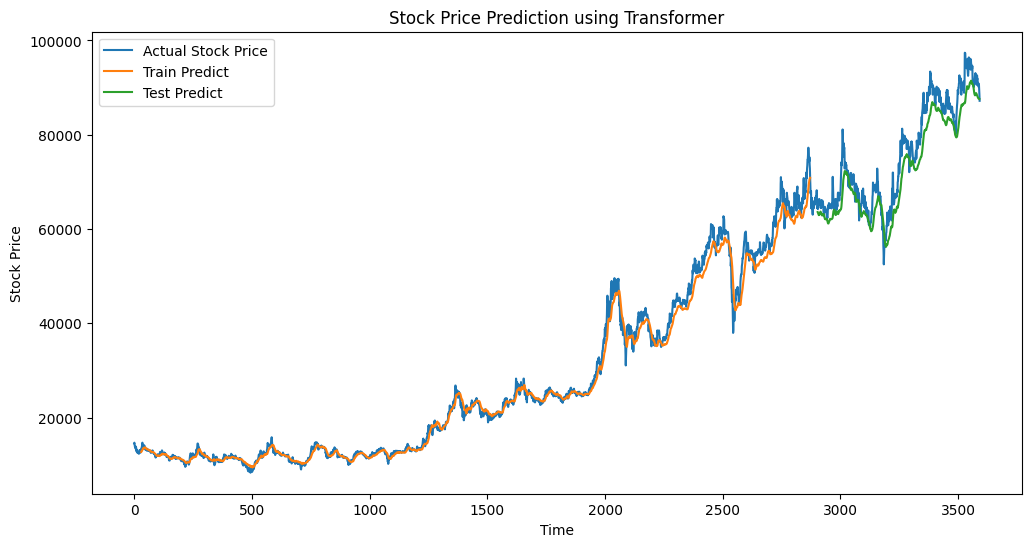

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D
from sklearn.metrics import mean_squared_error, r2_score
import math
import matplotlib.pyplot as plt
import os
from filterpy.kalman import KalmanFilter

# Load and prepare the dataset
file_path = '/mnt/d/code/TimeSeries/Nhom1_CuoiKi_TimeSeries/Data/vcb_2010-2024.csv'  # Make sure to have your dataset ready
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df[::-1].reset_index(drop=True)
df.set_index('Date', inplace=True)
data = df[['Close']].values
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Apply Kalman Filter to smooth the data
def apply_kalman_filter(data):
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([0., 0.])
    kf.F = np.array([[1., 1.], [0., 1.]])
    kf.H = np.array([[1., 0.]])
    kf.P *= 1000.
    kf.R = 5
    kf.Q = np.array([[1., 0.], [0., 1.]])
    smoothed_data = []
    for measurement in data:
        kf.predict()
        kf.update(measurement)
        smoothed_data.append(kf.x[0])
    return np.array(smoothed_data).reshape(-1, 1)

data_kalman = apply_kalman_filter(data_scaled)

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step)]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])  # Only take the 'Close' value for y
    return np.array(dataX), np.array(dataY)

# Parameters
time_step = 30
training_size = int(len(data_kalman) * 0.8)
test_size = len(data_kalman) - training_size
train_data, test_data = data_kalman[0:training_size], data_kalman[training_size:len(data_kalman)]

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input for the model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Transformer Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

# Model Definition
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = transformer_encoder(inputs, head_size=256, num_heads=4, ff_dim=4, dropout=0.1)
x = GlobalAveragePooling1D(data_format='channels_first')(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
outputs = Dense(1, activation="linear")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="mean_squared_error")

# Model Summary
model.summary()

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict_inverse = scaler.inverse_transform(train_predict)
test_predict_inverse = scaler.inverse_transform(test_predict)
y_train_inverse = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
train_rmse = math.sqrt(mean_squared_error(y_train_inverse, train_predict_inverse))
test_rmse = math.sqrt(mean_squared_error(y_test_inverse, test_predict_inverse))
train_r2 = r2_score(y_train_inverse, train_predict_inverse)
test_r2 = r2_score(y_test_inverse, test_predict_inverse)

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Train R2: {train_r2}")
print(f"Test R2: {test_r2}")

# Path to save the model
model_path = "best_transformer_model_kalman.h5"

# Check if a model already exists
if os.path.exists(model_path):
    # Load the existing model
    best_model = tf.keras.models.load_model(model_path)
    
    # Evaluate the existing model
    best_model_predict = best_model.predict(X_test)
    best_model_predict_inverse = scaler.inverse_transform(best_model_predict)
    best_model_r2 = r2_score(y_test_inverse, best_model_predict_inverse)
    
    # Compare the new model with the existing model
    if test_r2 > best_model_r2:
        print(f"New model is better (Test R2: {test_r2} > {best_model_r2}). Updating the saved model.")
        model.save(model_path)
    else:
        print(f"Existing model is better (Test R2: {best_model_r2} >= {test_r2}). Not updating the saved model.")
else:
    # Save the new model
    model.save(model_path)
    print(f"No existing model found. Saving the new model.")

# Plotting the results
# Adjust the time_step offset for plotting
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(train_predict_inverse)+time_step, :] = train_predict_inverse

# Shift test predictions for plotting
testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict_inverse)+(time_step*2)+1:len(data_scaled)-1, :] = test_predict_inverse

# Plot baseline and predictions
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(data_scaled), label='Actual Stock Price')
plt.plot(trainPredictPlot, label='Train Predict')
plt.plot(testPredictPlot, label='Test Predict')
plt.title('Stock Price Prediction using Transformer')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [14]:
import tensorflow as tf
import numpy as np
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model_path = "/mnt/d/code/TimeSeries/Nhom1_CuoiKi_TimeSeries/best_transformer_model_kalman.h5"
def nash_sutcliffe_efficiency(y_true, y_pred):
    return 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))

# Load the trained model
best_model = tf.keras.models.load_model(model_path)

# Predict using the model
best_model_predict = best_model.predict(X_test)
best_model_predict_inverse = scaler.inverse_transform(best_model_predict)

# Ensure y_test is reshaped correctly
if y_test.ndim == 1:
    y_test = y_test.reshape(-1, 1)
y_test_inverse = scaler.inverse_transform(y_test)

# Calculate evaluation metrics
r2 = r2_score(y_test_inverse, best_model_predict_inverse)
nse = nash_sutcliffe_efficiency(y_test_inverse, best_model_predict_inverse)
mae = mean_absolute_error(y_test_inverse, best_model_predict_inverse)
rmse = math.sqrt(mean_squared_error(y_test_inverse, best_model_predict_inverse))

# Print the results
print(f"R2: {r2}")
print(f"NSE: {nse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

22/22 [==============================] - 0s 3ms/step
R2: 0.9567527540812841
NSE: 0.9567527540812841
MAE: 1712.2169540075433
RMSE: 2283.0332046175654


## Mô hình Kalman test tiếp

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 60, 1)]      0           []                               
                                                                                                  
 layer_normalization_4 (LayerNo  (None, 60, 1)       2           ['input_3[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 multi_head_attention_2 (MultiH  (None, 60, 1)       7169        ['layer_normalization_4[0][0]',  
 eadAttention)                                                    'layer_normalization_4[0][0]']  
                                                                                            

/tmp/ipykernel_806/3305290743.py:16: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)


 obalAveragePooling1D)                                                                            
                                                                                                  
 dropout_12 (Dropout)           (None, 60)           0           ['global_average_pooling1d_2[0][0
                                                                 ]']                              
                                                                                                  
 dense_10 (Dense)               (None, 20)           1220        ['dropout_12[0][0]']             
                                                                                                  
 dense_11 (Dense)               (None, 1)            21          ['dense_10[0][0]']               
                                                                                                  
Total params: 8,427
Trainable params: 8,427
Non-trainable params: 0
_________________________________________

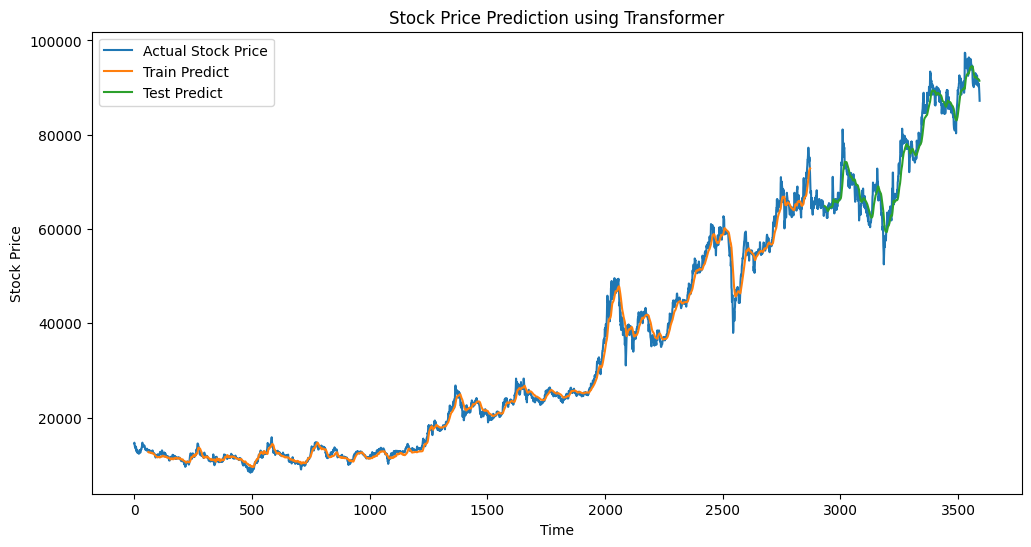

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D
from sklearn.metrics import mean_squared_error, r2_score
import math
import matplotlib.pyplot as plt
import os
from filterpy.kalman import KalmanFilter

# Load and prepare the dataset
file_path = '/mnt/d/code/TimeSeries/Nhom1_CuoiKi_TimeSeries/Data/vcb_2010-2024.csv'  # Make sure to have your dataset ready
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df[::-1].reset_index(drop=True)
df.set_index('Date', inplace=True)
data = df[['Close']].values
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Apply Kalman Filter to smooth the data
def apply_kalman_filter(data):
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([0., 0.])
    kf.F = np.array([[1., 1.], [0., 1.]])
    kf.H = np.array([[1., 0.]])
    kf.P *= 1000.
    kf.R = 5
    kf.Q = np.array([[1., 0.], [0., 1.]])
    smoothed_data = []
    for measurement in data:
        kf.predict()
        kf.update(measurement)
        smoothed_data.append(kf.x[0])
    return np.array(smoothed_data).reshape(-1, 1)

data_kalman = apply_kalman_filter(data_scaled)

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step)]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])  # Only take the 'Close' value for y
    return np.array(dataX), np.array(dataY)

# Parameters
time_step = 60
training_size = int(len(data_kalman) * 0.8)
test_size = len(data_kalman) - training_size
train_data, test_data = data_kalman[0:training_size], data_kalman[training_size:len(data_kalman)]

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input for the model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Transformer Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

# Model Definition
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = transformer_encoder(inputs, head_size=256, num_heads=4, ff_dim=4, dropout=0.1)
x = GlobalAveragePooling1D(data_format='channels_first')(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
outputs = Dense(1, activation="linear")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="mean_squared_error")

# Model Summary
model.summary()

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict_inverse = scaler.inverse_transform(train_predict)
test_predict_inverse = scaler.inverse_transform(test_predict)
y_train_inverse = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the model
train_rmse = math.sqrt(mean_squared_error(y_train_inverse, train_predict_inverse))
test_rmse = math.sqrt(mean_squared_error(y_test_inverse, test_predict_inverse))
train_r2 = r2_score(y_train_inverse, train_predict_inverse)
test_r2 = r2_score(y_test_inverse, test_predict_inverse)

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Train R2: {train_r2}")
print(f"Test R2: {test_r2}")

# Path to save the model
model_path = "best_transformer_model_kalman2.h5"

# Check if a model already exists
if os.path.exists(model_path):
    # Load the existing model
    best_model = tf.keras.models.load_model(model_path)
    
    # Evaluate the existing model
    best_model_predict = best_model.predict(X_test)
    best_model_predict_inverse = scaler.inverse_transform(best_model_predict)
    best_model_r2 = r2_score(y_test_inverse, best_model_predict_inverse)
    
    # Compare the new model with the existing model
    if test_r2 > best_model_r2:
        print(f"New model is better (Test R2: {test_r2} > {best_model_r2}). Updating the saved model.")
        model.save(model_path)
    else:
        print(f"Existing model is better (Test R2: {best_model_r2} >= {test_r2}). Not updating the saved model.")
else:
    # Save the new model
    model.save(model_path)
    print(f"No existing model found. Saving the new model.")

# Plotting the results
# Adjust the time_step offset for plotting
trainPredictPlot = np.empty_like(data_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(train_predict_inverse)+time_step, :] = train_predict_inverse

# Shift test predictions for plotting
testPredictPlot = np.empty_like(data_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict_inverse)+(time_step*2)+1:len(data_scaled)-1, :] = test_predict_inverse

# Plot baseline and predictions
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(data_scaled), label='Actual Stock Price')
plt.plot(trainPredictPlot, label='Train Predict')
plt.plot(testPredictPlot, label='Test Predict')
plt.title('Stock Price Prediction using Transformer')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [12]:
import tensorflow as tf
import numpy as np
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model_path = "/mnt/d/code/TimeSeries/Nhom1_CuoiKi_TimeSeries/best_transformer_model_kalman2.h5"
def nash_sutcliffe_efficiency(y_true, y_pred):
    return 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))

# Load the trained model
best_model = tf.keras.models.load_model(model_path)

# Predict using the model
best_model_predict = best_model.predict(X_test)
best_model_predict_inverse = scaler.inverse_transform(best_model_predict)

# Ensure y_test is reshaped correctly
if y_test.ndim == 1:
    y_test = y_test.reshape(-1, 1)
y_test_inverse = scaler.inverse_transform(y_test)

# Calculate evaluation metrics
r2 = r2_score(y_test_inverse, best_model_predict_inverse)
nse = nash_sutcliffe_efficiency(y_test_inverse, best_model_predict_inverse)
mae = mean_absolute_error(y_test_inverse, best_model_predict_inverse)
rmse = math.sqrt(mean_squared_error(y_test_inverse, best_model_predict_inverse))

# Print the results
print(f"R2: {r2}")
print(f"NSE: {nse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

21/21 [==============================] - 0s 14ms/step
R2: 0.9487415117110833
NSE: 0.9487415117110833
MAE: 1909.9144100521307
RMSE: 2483.4760976515204


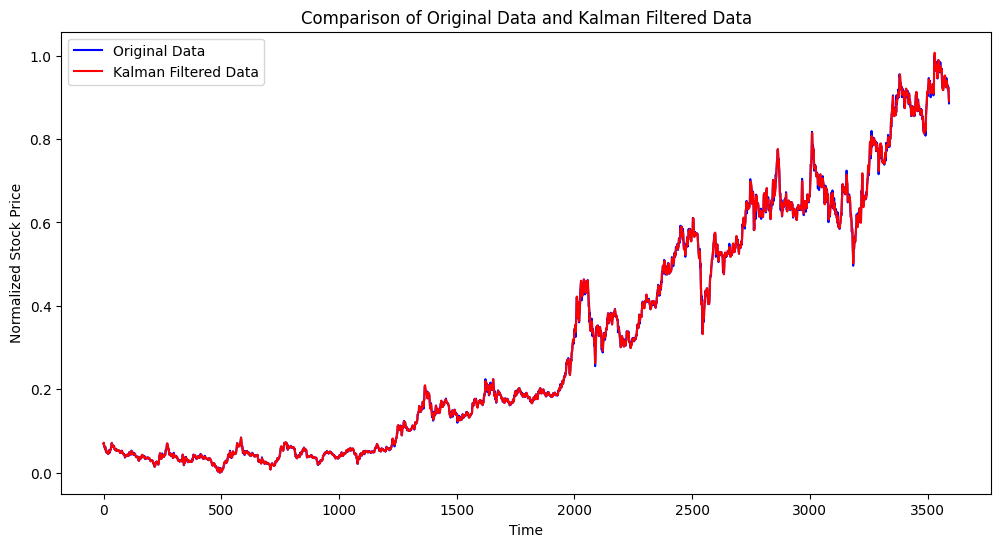

In [15]:
# Plot the data before and after applying Kalman Filter
plt.figure(figsize=(12, 6))
plt.plot(data_scaled, label='Original Data', color='blue')
plt.plot(data_kalman, label='Kalman Filtered Data', color='red')
plt.title('Comparison of Original Data and Kalman Filtered Data')
plt.xlabel('Time')
plt.ylabel('Normalized Stock Price')
plt.legend()
plt.show()


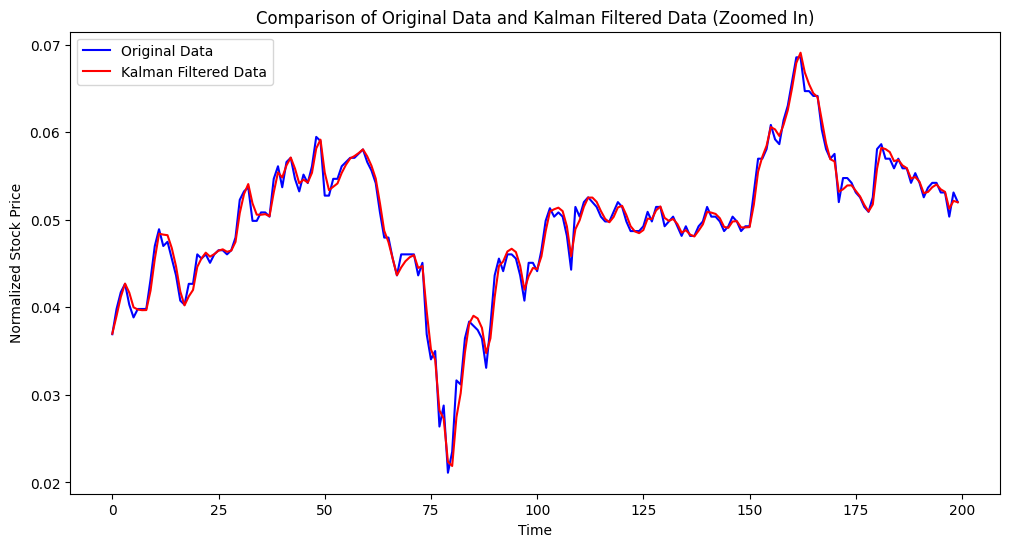

In [16]:
# Plot a smaller segment of the data before and after applying Kalman Filter
start_idx = 1000
end_idx = 1200

plt.figure(figsize=(12, 6))
plt.plot(data_scaled[start_idx:end_idx], label='Original Data', color='blue')
plt.plot(data_kalman[start_idx:end_idx], label='Kalman Filtered Data', color='red')
plt.title('Comparison of Original Data and Kalman Filtered Data (Zoomed In)')
plt.xlabel('Time')
plt.ylabel('Normalized Stock Price')
plt.legend()
plt.show()


### in thông tin cơ bản của model

In [17]:
import tensorflow as tf
import pickle
import os

# Load the saved model
model_path = "best_transformer_model_kalman2.h5"
model = tf.keras.models.load_model(model_path)

# Print model architecture
model.summary()

# Print model configuration
config = model.get_config()
print("Model Configuration:")
print(config)

# Load and print training history
history_path = "training_history.pkl"
if os.path.exists(history_path):
    with open(history_path, 'rb') as file:
        history = pickle.load(file)
    print("Training History:")
    print(history)

    # Print number of epochs
    num_epochs = len(history['loss'])
    print(f"Number of epochs trained: {num_epochs}")
else:
    print("No training history file found.")


Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 60, 1)]      0           []                               
                                                                                                  
 layer_normalization_32 (LayerN  (None, 60, 1)       2           ['input_17[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_16 (Multi  (None, 60, 1)       7169        ['layer_normalization_32[0][0]', 
 HeadAttention)                                                   'layer_normalization_32[0][0]'] 
                                                                                           